# <img style="float: left; padding: 0px 10px 0px 0px;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg/1920px-Escudo_de_la_Pontificia_Universidad_Cat%C3%B3lica_de_Chile.svg.png"  width="80" /> IMT2118 - Ciencia de Datos Geoespaciales
**Pontificia Universidad Católica de Chile**<br>
**Semestre 2024-1**<br>
**Profesora:** Paula Aguirre <br>
**Ayudante:** Diego Pizarro <br>
**Integrantes:** Alu "Cachetes" Palu,Bastian Baez Oses
<br>





---

In [100]:
import geopandas as gpd
import geemap
import ee
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
import pandas as pd
import folium

In [101]:
#Inicializamos GEE
ee.Authenticate();
ee.Initialize(project='ee-bastianbaezos') #use su código de proyecto

In [102]:
# Funcion sacada de la ay. 4
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True, show=False).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [103]:
def getAOI(dat,crs=4326):
    aoi_coords = list(dat.geometry.unary_union.exterior.coords)
    aoi = ee.Geometry.Polygon(aoi_coords)
    return aoi

# La siguiente función fue sacada de:
# https://github.com/gee-community/geemap/issues/1095#issuecomment-1151812523
def fmask(image):
    # see https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC09_C02_T1_L2
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True).updateMask(qaMask)

def get_images(year_init, year_end, aoi):
    # Funcion creada usando de base la de la ayudantia 4
    years = list(range(year_init, year_end + 1))
    annual_imgs = {year: '' for year in years}

    for year in years:
        startDate = f'{year}-01-01'
        endDate = f'{year}-12-31'

        sentinelImageCollection = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2').filterBounds(aoi).filterDate(startDate, endDate)

        # Aplicamos fmask
        sentinelImageCollection = sentinelImageCollection.map(fmask)

        bandas = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']

        # Seleccionamos las bandas de interés
        sentinelImageCollection = sentinelImageCollection.select(bandas)

        # Geomedian ee.Reducer.geometricMedian()
        image = sentinelImageCollection.reduce(ee.Reducer.geometricMedian(numX=6)).clip(aoi)

        # Cambiar nombre de las bandas a "bandas"
        image = image.rename(bandas)

        # Agregar imagen al diccionario
        annual_imgs[year] = image

    return annual_imgs

In [104]:
# Include the following indices - Normalized difference built-up index (NDBI), 
# Normalized Difference Thermal Index (NDTI) and Buildup Index (BUI)

#Codigo obtenido de https://github.com/amasud08/Project_MRes/blob/main/notebooks/3_image_statistics.ipynb
#modificado para su uso en esta parte
def indices(img):
    
    #bandas = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7']
    img = img.select(
        ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"])
    
    # calculate ndbi
    ndbi = img.normalizedDifference(["SWIR1", "NIR"]).rename('NDBI')
    
    # calculate mndbi
    mndbi = img.normalizedDifference(["SWIR2", "Blue"]).rename('MNDBI')
    
    
    buiA = img.expression("(SWIR1 - NIR) / (SWIR1 + NIR)", {
        "SWIR1": img.select("SWIR1"),
        "NIR": img.select("NIR")
    }).rename("BUI_A")
    
    buiB = img.expression("(NIR - Red) / (NIR + Red)", {
        "NIR": img.select("NIR"),
        "Red": img.select("Red")
    }).rename("BUI_B")
        
    bui_AB = buiA.addBands(buiB);
    bui = bui_AB.normalizedDifference(["BUI_A", "BUI_B"]).rename("BUI")
    
    #Calculate Index-Based Built-Up Index (IBI)
    # https://bikeshbade.com.np/tutorials/Detail/?title=Most%20used%20spectral%20Indices%20with%20free%20satellite%20data&code=23
    ibiA = img.expression('2 * SWIR1 / (SWIR1 + NIR)', {
        'SWIR1': img.select('SWIR1'),
        'NIR'  : img.select('NIR')}).rename("IBI_A")
    
    ibiB = img.expression('(NIR / (NIR + Red)) + (Green / (Green + SWIR1))', {
        "NIR"  : img.select("NIR"),
        "Red"  : img.select("Red"),
        "Green": img.select("Green"),
        "SWIR1": img.select("SWIR1")}).rename("IBI_B")
    
    ibiAB = ibiA.addBands(ibiB);
    ibi = ibiAB.normalizedDifference(["IBI_A", "IBI_B"]).rename("IBI")
    
    
    # Calculate ENDISI - https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Urban_change_detection.html
    swir_diff = img.expression("SWIR1 / SWIR2", {"SWIR1": img.select("SWIR1"), "SWIR2": img.select("SWIR2"),
                                                }).rename('swir_diff')
    
     
    mndwi = img.normalizedDifference(["Green", "SWIR1"]).rename('MNDWI')
 
    img = img.addBands([swir_diff, mndwi])
    
    blue_mean = img.select("Blue").reduceRegion(ee.Reducer.mean(), aoi).toImage().rename("blue_mean")
    
    swir_mean = img.select("swir_diff").reduceRegion(ee.Reducer.mean(), aoi).toImage().rename("swir_mean")
    
    mndwi_mean = img.select("MNDWI").multiply(img.select("MNDWI")).reduceRegion(ee.Reducer.mean(), aoi).toImage().rename("mndwi_mean")
    
    img = img.addBands([blue_mean, swir_mean, mndwi_mean])
    
    alpha = img.expression('(2 * b("blue_mean")) / (b("swir_mean") +  b("mndwi_mean"))').rename("alpha")
    
    img = img.addBands(alpha)
    
    ENDISI = img.expression('(b("Blue") - b("alpha") * (b("swir_diff") + b("MNDWI")**2)) / (b("Blue") + b("alpha") * (b("swir_diff") + b("MNDWI")**2))').rename("ENDISI")

    img = img.addBands(ENDISI)
    
    return  img

# Comunas

In [105]:
# Nuestro crs
n_crs = 4326

In [106]:
# obtener poligonos de comunas
comunas=gpd.read_file('Datos\R13\COMUNA_C17.shp')
display(comunas.head(5))
comunas = comunas.to_crs(epsg=n_crs)

# Crs de las comunas
print(comunas.crs)

# imprimir nombre de las comunas, para seleccionar la que queremos
print(comunas['NOM_COMUNA'].unique())

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,1.625330,0.066035,"POLYGON ((-70.61889 -33.73808, -70.61811 -33.7..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13402,BUIN,0.884164,0.021166,"POLYGON ((-70.63192 -33.64634, -70.63207 -33.6..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78914 -33.36153, -70.78824 -33.3..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13103,CERRO NAVIA,0.170180,0.001076,"POLYGON ((-70.71927 -33.41334, -70.71888 -33.4..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,133,CHACABUCO,13301,COLINA,1.692007,0.093820,"POLYGON ((-70.59630 -32.95138, -70.59673 -32.9..."


EPSG:4326
['PAINE' 'BUIN' 'PUDAHUEL' 'CERRO NAVIA' 'COLINA' 'TILTIL' 'LAMPA'
 'HUECHURABA' 'CONCHALÍ' 'MARÍA PINTO' 'CURACAVÍ' 'LA PINTANA' 'EL BOSQUE'
 'ESTACIÓN CENTRAL' 'PEDRO AGUIRRE CERDA' 'RECOLETA' 'INDEPENDENCIA'
 'ISLA DE MAIPO' 'LO ESPEJO' 'LA CISTERNA' 'LA FLORIDA' 'PEÑALOLÉN'
 'LAS CONDES' 'LA REINA' 'LO BARNECHEA' 'VITACURA' 'QUINTA NORMAL'
 'LO PRADO' 'CERRILLOS' 'MAIPÚ' 'MELIPILLA' 'MACUL' 'ÑUÑOA' 'PEÑAFLOR'
 'PADRE HURTADO' 'PUENTE ALTO' 'QUILICURA' 'RENCA' 'CALERA DE TANGO'
 'SAN BERNARDO' 'SAN JOSÉ DE MAIPO' 'PIRQUE' 'SAN JOAQUÍN' 'SAN MIGUEL'
 'SAN RAMÓN' 'LA GRANJA' 'PROVIDENCIA' 'SANTIAGO' 'EL MONTE' 'TALAGANTE'
 'SAN PEDRO' 'ALHUÉ']


In [107]:
# Escogemos las comunas que queremos
m_comunas = "CERRILLOS,CERRO NAVIA,CONCHALÍ,EL BOSQUE,ESTACIÓN CENTRAL,HUECHURABA,INDEPENDENCIA,LA CISTERNA,LA FLORIDA,LA GRANJA,LA PINTANA,LA REINA,LAS CONDES,LO BARNECHEA,LO ESPEJO,LO PRADO,MACUL,MAIPÚ,ÑUÑOA,PEDRO AGUIRRE CERDA,PEÑALOLÉN,PROVIDENCIA,PUDAHUEL,PUENTE ALTO,QUILICURA,QUINTA NORMAL,RECOLETA,RENCA,SAN BERNARDO,SAN JOAQUÍN,SAN MIGUEL,SAN RAMÓN,SANTIAGO,VITACURA".split(',')
print(m_comunas)
print(len(m_comunas))
# ELIMINAR "LO BARNECHEA" DE LA LISTA DE COMUNAS
m_comunas.remove("LO BARNECHEA")
# Filtrar comunas
comunas = comunas[comunas.NOM_COMUNA.isin(m_comunas)]
display(comunas.head(5))

['CERRILLOS', 'CERRO NAVIA', 'CONCHALÍ', 'EL BOSQUE', 'ESTACIÓN CENTRAL', 'HUECHURABA', 'INDEPENDENCIA', 'LA CISTERNA', 'LA FLORIDA', 'LA GRANJA', 'LA PINTANA', 'LA REINA', 'LAS CONDES', 'LO BARNECHEA', 'LO ESPEJO', 'LO PRADO', 'MACUL', 'MAIPÚ', 'ÑUÑOA', 'PEDRO AGUIRRE CERDA', 'PEÑALOLÉN', 'PROVIDENCIA', 'PUDAHUEL', 'PUENTE ALTO', 'QUILICURA', 'QUINTA NORMAL', 'RECOLETA', 'RENCA', 'SAN BERNARDO', 'SAN JOAQUÍN', 'SAN MIGUEL', 'SAN RAMÓN', 'SANTIAGO', 'VITACURA']
34


,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,SHAPE_Leng,SHAPE_Area,geometry
2,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,0.720176,0.019124,"POLYGON ((-70.78914 -33.36153, -70.78824 -33.3..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13103,CERRO NAVIA,0.170180,0.001076,"POLYGON ((-70.71927 -33.41334, -70.71888 -33.4..."
7,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13107,HUECHURABA,0.326251,0.004350,"POLYGON ((-70.66312 -33.32923, -70.66276 -33.3..."
8,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13104,CONCHALÍ,0.138248,0.001077,"POLYGON ((-70.69041 -33.36579, -70.69028 -33.3..."
11,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13112,LA PINTANA,0.259374,0.002958,"POLYGON ((-70.63212 -33.55817, -70.63204 -33.5..."


In [108]:
aoi = getAOI(comunas)
aoi

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "GeometryConstructors.Polygon",
    "arguments": {
      "coordinates": {
        "constantValue": [
          [
            [
              -70.63216210499996,
              -33.64518685599995
            ],
            [
              -70.63238355099998,
              -33.64516477199993
            ],
            [
              -70.63277298299994,
              -33.645125933999964
            ],
            [
              -70.63346541499993,
              -33.64501785199997
            ],
            [
              -70.63362174499997,
              -33.64502476699994
            ],
            [
              -70.63386627099999,
              -33.645035581999934
            ],
            [
              -70.63444412799998,
              -33.64506114099993
            ],
            [
              -70.63544297899995,
              -33.64522284099996
            ],
            [
              -70.63646944199996,
              -33.645414725999956
            ],
            [
              -70.63647634299997,
              -33.645416015999956
            ],
            [
              -70.63670103599998,
              -33.64545696199997
            ],
            [
              -70.63734384599996,
              -33.645574102999944
            ],
            [
              -70.63762243499997,
              -33.64567071799996
            ],
            [
              -70.63835808699997,
              -33.645925844999965
            ],
            [
              -70.63900021899997,
              -33.64614853699993
            ],
            [
              -70.63919516899995,
              -33.64618787999996
            ],
            [
              -70.64015842299995,
              -33.646382277999976
            ],
            [
              -70.64224436399996,
              -33.64659764299995
            ],
            [
              -70.64232312999997,
              -33.646605774999955
            ],
            [
              -70.64265627899994,
              -33.64658580599996
            ],
            [
              -70.64332935699997,
              -33.64654546099996
            ],
            [
              -70.64408965199993,
              -33.646610083999974
            ],
            [
              -70.64412202999995,
              -33.64661894999995
            ],
            [
              -70.64418822599998,
              -33.646637075999934
            ],
            [
              -70.64438322699993,
              -33.64669047299998
            ],
            [
              -70.64459403399997,
              -33.646748197999955
            ],
            [
              -70.64479164999995,
              -33.64680231099993
            ],
            [
              -70.64480356299998,
              -33.64680429899994
            ],
            [
              -70.64522866399994,
              -33.64687523699996
            ],
            [
              -70.64523944499996,
              -33.64687703599998
            ],
            [
              -70.64527986199994,
              -33.646940564999966
            ],
            [
              -70.64532023999993,
              -33.64700207899995
            ],
            [
              -70.64557570299996,
              -33.647034832999964
            ],
            [
              -70.64601787699996,
              -33.64709152599994
            ],
            [
              -70.64617870199999,
              -33.647148984999944
            ],
            [
              -70.64637806999997,
              -33.64722021399996
            ],
            [
              -70.64677449099997,
              -33.64736184399993
            ],
            [
              -70.64693304799994,
              -33.64741849199993
            ],
            [
              -70.64696134899998,
              -33.647425331999955
            ],
            [
              -70.64716381799997,
              -

In [109]:
start_year = 2010
end_year = 2023

x,y =aoi.centroid().getInfo()["coordinates"]
dates=[start_year,end_year]
imagenes=get_images(start_year,end_year,aoi)
imagenes


{2010: <ee.image.Image at 0x1e6b2276150>,
 2011: <ee.image.Image at 0x1e6b22777d0>,
 2012: <ee.image.Image at 0x1e6b2274510>,
 2013: <ee.image.Image at 0x1e6b2291cd0>,
 2014: <ee.image.Image at 0x1e6b2290cd0>,
 2015: <ee.image.Image at 0x1e6b21d0110>,
 2016: <ee.image.Image at 0x1e6b21d3410>,
 2017: <ee.image.Image at 0x1e6aa9bf650>,
 2018: <ee.image.Image at 0x1e6b1c54490>,
 2019: <ee.image.Image at 0x1e6b21d1810>,
 2020: <ee.image.Image at 0x1e6b2282890>,
 2021: <ee.image.Image at 0x1e6b2283cd0>,
 2022: <ee.image.Image at 0x1e6b1759190>,
 2023: <ee.image.Image at 0x1e6b17595d0>}

In [110]:
# Visualización de las imágenes
visualization_rgb = {
    'bands': ['SR_B3', 'SR_B2', 'SR_B1'],
    'min': 0.0,
    'max': 0.3,
}
fmap = folium.Map(location=[y,x], zoom_start=10)

for year in imagenes.keys():
    image = imagenes[year]
    fmap.add_ee_layer(image, visualization_rgb, name=str(year))

fmap.add_child(folium.LayerControl())
display(fmap)


In [111]:
# Codigo inspirado en ayudantia 4
video_args_rgb = {
    'dimensions': (1200,600),
    'region': aoi,
    'framesPerSecond': 1,
    'crs': 'EPSG:4326',
    'min': 0.0,
    'max': 0.3,
    'bands': ['SR_B3', 'SR_B2', 'SR_B1']
}

# Convertir el diccionario de imagenes a una coleccion de imagenes
timelapse_imagenes = list(imagenes.values())
timelapse_imagenes = ee.ImageCollection.fromImages(timelapse_imagenes)

# Crear el gif
gif_url = timelapse_imagenes.getVideoThumbURL(video_args_rgb)
gif_url

# Codigo inspirado de https://book.geemap.org/chapters/09_timelapse.html

in_gif = r'imagenes-gif\timelapse.gif'
on_gif = r'imagenes-gif\timelapse_with_text.gif'
geemap.download_file(gif_url, in_gif, overwrite=True)
geemap.add_text_to_gif(
    in_gif,
    on_gif,
    xy=('3%', '5%'),
    text_sequence=start_year,
    font_size=30,
    font_color='#ffffff',
    add_progress_bar=True,
    progress_bar_color='#ffffff',
    progress_bar_height=5,
    duration=1000,
    loop=0,
)

geemap.show_image(on_gif)

geemap.download_file

Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-bastianbaezos/videoThumbnails/e8479bc98bee615d780b2847e30585f4-3a54b7b3d9193da0c0564057fc316c7e:getPixels
To: c:\Users\itsab\OneDrive\Escritorio\Universidad\2024-1\IMT2118 - Geo\Proyecto-Geoespaciales\imagenes-gif\timelapse.gif
100%|██████████| 2.60M/2.60M [00:01<00:00, 1.78MB/s]


Output()

<function geemap.common.download_file(url=None, output=None, quiet=False, proxy=None, speed=None, use_cookies=True, verify=True, id=None, fuzzy=False, resume=False, unzip=True, overwrite=False)>

In [112]:
imagenes = {year: indices(img) for year, img in imagenes.items()}

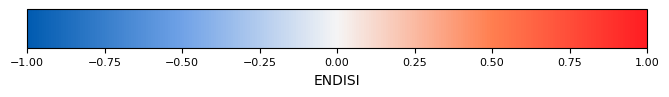

In [113]:

vmin = -1
vmax = 1
# Lista de paleta de colores
smooth_colors = ['#005bb0', '#70a2e7', '#f5f5f5', '#ff7f50', '#ff1c22'] 


# Palette de colores
smooth_cmap = mcolors.LinearSegmentedColormap.from_list('smooth_cmap', ['#005bb0', '#70a2e7', '#f5f5f5', '#ff7f50', '#ff1c22'])


# Crear una figura de matplotlib para el colorbar
fig, ax = plt.subplots(figsize=(8, 0.5))
norm = plt.Normalize(vmin=vmin, vmax=vmax)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=smooth_cmap), 
                  cax=ax, orientation='horizontal')
cb.set_label('ENDISI', fontsize=10)
cb.ax.tick_params(labelsize=8)

# Guardar el colorbar como una imagen
colorbar_file = 'imagenes-gif/colorbar.png'
plt.savefig(colorbar_file, bbox_inches='tight', dpi=300)

In [114]:
# Convertir el diccionario de imagenes a una coleccion de imagenes
timelapse_imagenes = list(imagenes.values())
timelapse_imagenes = ee.ImageCollection.fromImages(timelapse_imagenes)

# Crea el gif con las zonas y las imágenes de NDBI
video_args = {
    'dimensions': (1200,600),
    'region': aoi,
    'framesPerSecond': 1,
    'crs': 'EPSG:4326',
    'min': vmin,
    'max': vmax,
    'bands': ['ENDISI'],
    'palette': smooth_colors
}

gif_url = timelapse_imagenes.getVideoThumbURL(video_args)

in_gif = r'imagenes-gif\timelapse_ENDISI.gif'
geemap.download_file(gif_url, in_gif, overwrite=True)
geemap.show_image(in_gif)


Downloading...
From: https://earthengine.googleapis.com/v1/projects/ee-bastianbaezos/videoThumbnails/04d5c7b6e8770cb38f995a225df9afa4-3399debbda4c70b002ef21a15b0b08fd:getPixels
To: c:\Users\itsab\OneDrive\Escritorio\Universidad\2024-1\IMT2118 - Geo\Proyecto-Geoespaciales\imagenes-gif\timelapse_ENDISI.gif
100%|██████████| 2.76M/2.76M [00:01<00:00, 2.39MB/s]


Output()

In [115]:
# Agregar años al gif
on_gif = r'imagenes-gif\timelapse_ENDISI_text.gif'
geemap.add_text_to_gif(
    in_gif,
    on_gif,
    xy=('3%', '5%'),
    text_sequence=start_year,
    font_size=30,
    font_color='white',
    add_progress_bar=True,
    progress_bar_color='#ffffff',
    progress_bar_height=5,
    duration=1000,
    loop=0,
)
geemap.add_image_to_gif(in_gif=on_gif, out_gif=on_gif, in_image=colorbar_file, xy = ('55%', '80%'), image_size=(1200, 80))
geemap.show_image(on_gif)

Output()